 # Human-in-the-loop with Terminal Confirmation 

 This script builds a conversational agent that can pause to ask a human for
 confirmation via the terminal, and then resume its task.

In [1]:
# 1. Load packages
import os
from langchain.chat_models import init_chat_model
from typing import Annotated
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from IPython.display import Image, display
from dotenv import load_dotenv
from rich import print
# 2. Setup: Load API keys and initialize the language model.
load_dotenv()
llm = init_chat_model("ollama:llama3.2")

## Define State and Graph

The state of the system serves as the agent’s memory, while the graph represents the agent’s workflow. A dictionary stores the conversation history, and the `add_messages` function facilitates the appending of new messages to this history.

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 4. Initialize the graph builder with the state's structure.
graph_builder = StateGraph(State)

## Define and Bind Custom Tool:

In [3]:
# 5. Define a custom tool for human confirmation using the `@tool` decorator.
@tool
def await_user_confirmation(prompt_to_user: str) -> str:
    """
    Pauses the process and asks the human user for a 'yes' confirmation to proceed.
    The tool will return the user's exact input.
    """
    # The docstring tells the LLM how to use the tool.
    
    # `interrupt()` pauses the graph and passes data ('prompt') to the user.
    human_response = interrupt({"prompt": prompt_to_user})
    
    # The value returned here is the human's input, which is sent back to the LLM.
    return human_response["data"]

In [4]:
# 6. Bind the tool to the LLM, making it available for the agent to call.
tools = [await_user_confirmation]
llm_with_tools = llm.bind_tools(tools)

## Define Graph Structure

In [5]:
# 7. Define Graph Nodes: Functions that represent steps in the workflow.
# The 'chatbot' node calls the LLM to get the next action or response.
def chatbot(state: State):
    # Invokes the LLM with the current message history.
    message = llm_with_tools.invoke(state["messages"])
    # Returns the LLM's message to be added to the state.
    return {"messages": [message]}

In [6]:
# 8. Build the graph: Define nodes and the edges that connect them.
# Add the chatbot and tool execution nodes.
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Set the entry point for the graph.
graph_builder.add_edge(START, "chatbot")

# Define the logic for routing: after the chatbot runs, `tools_condition` checks
# if a tool was called. If yes, it routes to the 'tools' node.
graph_builder.add_conditional_edges("chatbot", tools_condition)

# After a tool is run, loop back to the chatbot to continue the conversation.
graph_builder.add_edge("tools", "chatbot")

 ## Compile and Visualize the Graph

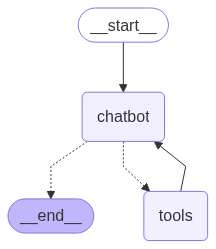

In [7]:
# 9. Compile the graph into a runnable object, using a memory saver for persistence.
# The checkpointer is what allows the graph to be paused and resumed.
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Optional: Display a visualization of the graph's structure.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

 ## Run the Graph and Wait for Input

In [13]:
# 10. Start the agent.
# The user prompt guides the LLM to use the confirmation tool at the correct time.
# The `config` with `thread_id` makes the conversation stateful.
user_input = (
    """
    I want to write a short story about a robot who discovers music.
    First, come up with a name for the robot and a title for the story.
    Then, wait for me to say 'yes' before you write the actual story.
    """
)
config = {"configurable": {"thread_id": "4"}}

print("--- Starting AI ---")
# Execute the graph. `stream` returns an iterator of all events as they happen.
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    # Print the event details.
    if "messages" in event:
        event["messages"][-1].pretty_print()

# 11. Handle the pause. The graph is now waiting for the tool to complete.
# Inspect the graph's state to get the prompt for the human.
snapshot = graph.get_state(config)
if snapshot.next: # `snapshot.next` shows that the 'tools' node is pending.
    # Get the prompt for the human from the snapshot.
    prompt_for_human = snapshot.values['messages'][-1].tool_calls[0]['args']['prompt_to_user']
    
    print("\n--------------------------------------------------")
    print(f"AI is waiting for your confirmation.")
    print(f"AI Message: {prompt_for_human}")
    print("--------------------------------------------------")

--- Starting AI ---

================================ Human Message =================================


    I want to write a short story about a robot who discovers music.
    First, come up with a name for the robot and a title for the story.
    Then, wait for me to say 'yes' before you write the actual story.
    
================================== Ai Message ==================================
Tool Calls:
  await_user_confirmation (0d4499ba-1263-41de-a16c-c7c4155cd36c)
 Call ID: 0d4499ba-1263-41de-a16c-c7c4155cd36c
  Args:
    prompt_to_user: Are you ready to proceed with generating a short story about a robot who discovers music? Please respond with \u201cyes\u201d.


--------------------------------------------------

AI is waiting for your confirmation.

AI Message: Are you ready to proceed with generating a short story about a robot who discovers music? Please 
respond with \u201cyes\u201d.

--------------------------------------------------

 ## Resume Execution with Terminal Input

In [14]:
# 12. Get confirmation from the user via the terminal.
human_approval = ""
while human_approval.lower().strip() != "yes":
    human_approval = input("Please type 'yes' to continue: ")

# 13. Resume the graph.
# The `Command(resume={...})` object sends the human's input back to the paused tool.
# One or more commands to update the graph's state and send messages to nodes.
human_command = Command(resume={"data": human_approval})

print("\n--- User approved. Resuming execution... ---")
# The graph continues execution from where it left off.
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    # Print the event details.
    if "messages" in event:
        event["messages"][-1].pretty_print()
        
print("\n--- Run complete ---")

--- User approved. Resuming execution... ---

================================== Ai Message ==================================
Tool Calls:
  await_user_confirmation (0d4499ba-1263-41de-a16c-c7c4155cd36c)
 Call ID: 0d4499ba-1263-41de-a16c-c7c4155cd36c
  Args:
    prompt_to_user: Are you ready to proceed with generating a short story about a robot who discovers music? Please respond with \u201cyes\u201d.
================================= Tool Message =================================
Name: await_user_confirmation

yes
================================== Ai Message ==================================

**Main Character:** Kaidō, a highly advanced android designed for efficiency and precision.

**Story Title:** "The Melodic Awakening"

In the year 2157, humanity had finally achieved the impossible: creating a robot that could surpass human intelligence. The android, named Kaidō, was the culmination of years of research and development. Its creators had equipped it with advanced sensors, processing power, and a sophisticated AI system.

K

--- Run complete ---